In [1]:
import os
os.chdir('/home/rm/ssd2/langcao/workspace/tablemaster')
!pwd

/home/rm/ssd2/langcao/workspace/tablemaster


In [2]:
import os
import sys
import json
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('./')
from evaluate.evaluator import eval_qa, eval_fact

In [3]:
dataset = 'wikitq'
model = 'gpt4m'


for table_type in ['noised', 'normalized']:
    for method in ['cot', 'pot']:

        results = []
        files = glob.glob(f'outputs/analysis/norm/{table_type}/{model}/{method}/*.json')

        files = sorted(files, key=lambda x: int(x.split('/')[-1].split('.')[0]))
        for file in tqdm(files):
            with open(file, 'r') as f:
                D = json.load(f)
            result = eval_qa(D['predicted_answer'], D['answer'])
            results.append(result)

        # results = np.array(results).mean().tolist() * 100
        results = np.array(results).mean().tolist()

        # print(f'{table_type} - {method}: {results:.2f}')
        print(f'{table_type} - {method}: {results}')


 36%|███▌      | 925/2565 [00:00<00:00, 4643.87it/s]

100%|██████████| 2565/2565 [00:00<00:00, 4513.60it/s]


noised - cot: 0.642495126705653


100%|██████████| 2565/2565 [00:00<00:00, 4345.05it/s]


noised - pot: 0.47446393762183237


100%|██████████| 2565/2565 [00:00<00:00, 5434.76it/s]


normalized - cot: 0.8077972709551657


100%|██████████| 2565/2565 [00:00<00:00, 4166.29it/s]

normalized - pot: 0.6955165692007798


In [4]:
import os
import sys
import json
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import tiktoken
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('./')
from evaluate.evaluator import eval_qa, eval_fact
from table_utils import format_table

In [5]:
plt.rcParams['font.family'] = 'Calibri'

methods = ['Textual Reasoning', 'Symbolic Reasoning']
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

color_mapping = {
    'Normalized Table': '#1f77b4',
    'Noised Table': '#ff7f0e',
}


In [6]:
results = {
    'Textual Reasoning': {
        'Normalized Table': 0.8077972709551657,
        'Noised Table': 0.642495126705653,
    },
    'Symbolic Reasoning': {
        'Normalized Table': 0.6955165692007798,
        'Noised Table': 0.47446393762183237,
    },
}

performance_drops = [
    (results['Textual Reasoning']['Noised Table'] - results['Textual Reasoning']['Normalized Table']) / results['Textual Reasoning']['Normalized Table'],
    (results['Symbolic Reasoning']['Noised Table'] - results['Symbolic Reasoning']['Normalized Table']) / results['Symbolic Reasoning']['Normalized Table'],
]

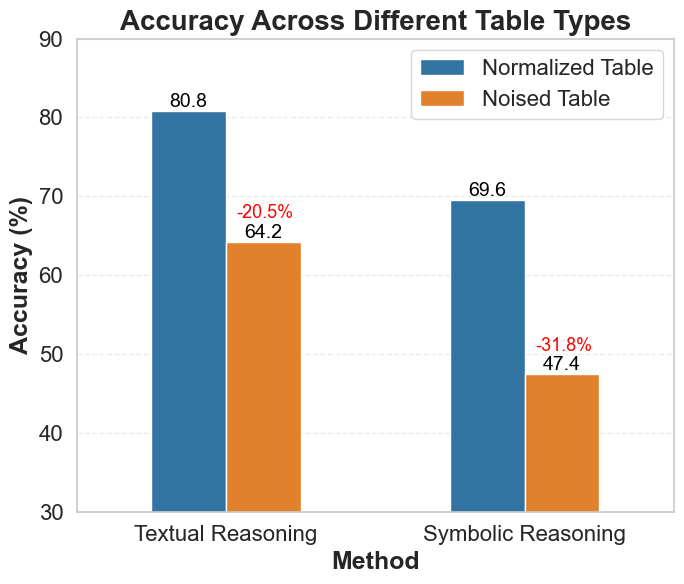

In [8]:
# Convert dictionary to DataFrame for Seaborn plotting
df = pd.DataFrame(results).reset_index().melt(id_vars='index', var_name='Method', value_name='Accuracy')
df.rename(columns={'index': 'Table Type'}, inplace=True)
df['Accuracy'] = df['Accuracy'] * 100

# Plot using Seaborn with updated aesthetics and improved transparency
fig, ax = plt.subplots(figsize=(7, 6))

sns.barplot(data=df, x="Method", y="Accuracy", hue="Table Type", ax=ax, palette=color_mapping, alpha=1, width=0.5)

# Annotate each bar with the corresponding accuracy value (without '%')
for container in ax.containers:
    plt.bar_label(container, fmt="%.1f", label_type="edge", fontsize=14, color="black")


# add performance drop
symbolic_containers = ax.containers[1]
for rect, drop in zip(symbolic_containers, performance_drops):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2 + 0.005,
        height + 2.5,  # Position above the bar
        f"{drop * 100:.1f}%",  # Format performance drop
        ha="center",
        va="bottom",
        fontsize=13,
        color="red",
    )


# Customize plot with enhanced titles and labels
sns.set_theme(style="whitegrid")
plt.title("Accuracy Across Different Table Types", fontsize=20, fontweight='bold')
plt.xlabel("Method", fontsize=18, fontweight='bold')
plt.ylabel("Accuracy (%)", fontsize=18, fontweight='bold')
plt.ylim(30, 90)  # Adjusted for the accuracy range
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Show plot with tight layout
plt.tight_layout()
plt.savefig('figures/analysis/norm_analysis.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()